# 목표
이전 FN 중심 오류 분석 결과를 바탕으로 입력 변수를 재검토하고 **치명 사고를 과소 예측하던 조건을 보완할 수 있도록 파생 변수를 추가**하며     
모델 학습에 기여하지 않는 불필요한 변수는 제거하여 사고 **치명도를 보다 안정적으로 예측할 수 있는 입력 구조를 설계**하는 것을 목표로 한다.

In [1]:
# 라이브러리
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
pd.reset_option("display.max_rows")
pd.reset_option("display.max_columns")
pd.reset_option("display.width")
pd.reset_option("display.max_colwidth")

In [3]:
# 데이터 불러오기 ( train만 사용 )
final_train = pd.read_csv("./data/final_Feature/train_final.csv")

In [1]:
# dtype 확인
final_train.dtypes

NameError: name 'final_train' is not defined

## 1. Date × Hour
- FN 분석에서 진행 한 피처 엔지니어링 동일하게 진행

In [5]:
# datetime으로 변환하기
final_train["Date_dt"] = pd.to_datetime(final_train["Date"], errors="coerce")

In [6]:
# weekday_name (요일 이름)생성
final_train["weekday_name"] = final_train["Date_dt"].dt.day_name()

In [7]:
# is_weekend (주말 여부) 생성
final_train["is_weekend"] = (final_train["Date_dt"].dt.weekday >= 5).astype(int)

In [8]:
# 시간만 추출하기
# timedelta로 변환
final_train["Hour_td"] = pd.to_timedelta(final_train["Hour"], errors="coerce")

In [9]:
# 시(hour)만 추출 (0~23)
final_train["hour_int"] = (final_train["Hour_td"].dt.total_seconds() // 3600).astype("Int64")

In [10]:
# 시간 그룹 생성 함수
def hour_group(h):
    if pd.isna(h):
        return pd.NA
    h = int(h)
    if 6 <= h <= 9:
        return "MorningRush"
    elif 10 <= h <= 15:
        return "Daytime"
    elif 16 <= h <= 19:
        return "EveningRush"
    elif 20 <= h <= 23:
        return "Night"
    else:
        return "LateNight"

final_train["hour_group"] = final_train["hour_int"].apply(hour_group)

In [11]:
# 생성 된 데이터 확인
final_train[["Date", "Date_dt", "weekday_name", "is_weekend", "Hour", "Hour_td", "hour_int", "hour_group"]].head(10)

,Date,Date_dt,weekday_name,is_weekend,Hour,Hour_td,hour_int,hour_group
0,2018-01-24,2018-01-24,Wednesday,0,0 days 15:05:00,0 days 15:05:00,15,Daytime
1,2018-02-12,2018-02-12,Monday,0,0 days 10:15:00,0 days 10:15:00,10,Daytime
2,2018-04-03,2018-04-03,Tuesday,0,0 days 11:35:00,0 days 11:35:00,11,Daytime
3,2018-05-05,2018-05-05,Saturday,1,0 days 17:35:00,0 days 17:35:00,17,EveningRush
4,2018-11-30,2018-11-30,Friday,0,0 days 17:15:00,0 days 17:15:00,17,EveningRush
5,2018-02-18,2018-02-18,Sunday,1,0 days 15:57:00,0 days 15:57:00,15,Daytime
6,2018-05-28,2018-05-28,Monday,0,0 days 18:30:00,0 days 18:30:00,18,EveningRush
7,2018-05-31,2018-05-31,Thursday,0,0 days 04:30:00,0 days 04:30:00,4,LateNight
8,2018-06-15,2018-06-15,Friday,0,0 days 08:45:00,0 days 08:45:00,8,MorningRush
9,2018-07-19,2018-07-19,Thursday,0,0 days 10:22:00,0 days 10:22:00,10,Daytime


In [12]:
# Date, Date_dt, Hour, Hour_td, hour_int 삭제 
final_train = final_train.drop(columns=["Date", "Date_dt", "Hour", "Hour_td", "hour_int"])

In [13]:
# 삭제 여부 확인
set(["Date", "Date_dt", "Hour", "Hour_td", "hour_int"]) & set(final_train.columns)

set()

## 2. Weather × Light
- 치명 사고에 대한 FN의 절대 다수는 ‘Normal’ 기상 조건과 ‘Daylight’ 조명 환경에서 발생했다.
- 이를 위해 'is_Daylight', 'is_Normal_Weather', 'is_Normal_Daylight' 변수를 생성한다.
- 해당 변수들을 통해 모델이 정상 환경으로 인식되는 조건에서도 치명 사고가 발생하는 패턴을 보다 명확히 학습할 수 있는지 확인한다.

In [14]:
# is_Daylight 생성
final_train["is_Daylight"] = (final_train["Light"] == "Daylight").astype(int)

# is_Normal_Weather 생성
final_train["is_Normal_Weather"] = (final_train["Weather"] == "Normal").astype(int)

# is_Normal_Daylight 생성 
final_train["is_Normal_Daylight"] = (
    (final_train["Weather"] == "Normal") & (final_train["Light"] == "Daylight")).astype(int)

## 3. Slope × SurfaceCondition
- 치명 사고에 대한 FN 분석시 경사가 없는 평지 구간과 미끄럼이나 악조건이 없는 정상 노면에서 발생했다.
- 이를 위해 'is_Flat_Slope', 'is_Normal_Surface', 'is_Flat_Normal_Surface' 변수를 생성한다.
- 이 또한 생성된 변수들을 통해 모델이 정상 환경으로 인식되는 조건에서 치명 사고 발생 패턴을 명확히 학습할 수 있는지 확인다.

In [15]:
# is_Flat_Slope 생성
final_train["is_flat_slope"] = (final_train["Slope"] == "Flat").astype(int)

# is_normal_surface 생성
final_train["is_normal_surface"] = (final_train["SurfaceCondition"] == "Normal").astype(int)

# is_flat_normal_surface 생성
final_train["is_flat_normal_surface"] = (
    (final_train["Slope"] == "Flat") & (final_train["SurfaceCondition"] == "Normal")).astype(int)

## 4. Layout × SurfaceCondition
- 치명 사고에 대한 FN 분석시 직선, 곡선 여부와 상관없이 Normal 노면에서 가장 많이 발생 되었다.
- 즉, 도로 형상 보다는 정상 노면과 일반적인 형상의 조합을 모델이 치명 사고 발생 패턴을 명확히 학슴할 수 있도록 한다.
- 이를 위해 'is_Straight_Layout', 'is_Straight_Normal_Surface' 변수를 생성한다.

In [16]:
# is_straight_layout 생성
final_train["is_Straight_Layout"] = (final_train["Layout"] == "Straight").astype(int)

# is_straight_normal_surface 생성
final_train["is_Straight_Normal_Surface"] = (
    (final_train["Layout"] == "Straight") & (final_train["SurfaceCondition"] == "Normal")).astype(int)

# 5. 모델 학습 후 변화 평가하기
- 파생된 변수 이외 모든 조건을 동일하게 적용하여 비교 분석한다.

In [17]:
# 라이브러리
from sklearn.model_selection import train_test_split

from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [18]:
# df_train에 학습용 변수 저장하기
df_train = final_train.drop(columns=["AccidentId", "Gravity", "PostalAddress", "GPSCode"])

In [19]:
# dtype 확인하기
df_train.dtypes

Light                         object
Department                     int64
Commune                        int64
InAgglomeration               object
IntersectionType              object
                               ...  
is_flat_slope                  int64
is_normal_surface              int64
is_flat_normal_surface         int64
is_Straight_Layout             int64
is_Straight_Normal_Surface     int64
Length: 146, dtype: object

In [20]:
# object 변수 선택
cols = [
    "Light", "InAgglomeration", "IntersectionType", "Weather",
    "CollisionType", "RoadType", "RoadLetter", "Circulation", "SpecialLane",
    "Slope", "Layout", "SurfaceCondition", "Infrastructure", "Localization",
    "weekday_name", "hour_group" 
]

In [21]:
# category 타입으로 변환
df_train[cols] = df_train[cols].astype("category")

In [22]:
# 최종 dtype 확인하기
df_train.dtypes

Light                         category
Department                       int64
Commune                          int64
InAgglomeration               category
IntersectionType              category
                                ...   
is_flat_slope                    int64
is_normal_surface                int64
is_flat_normal_surface           int64
is_Straight_Layout               int64
is_Straight_Normal_Surface       int64
Length: 146, dtype: object

In [23]:
# Y-train 만들기
y_train = final_train['Gravity']

In [24]:
# 변수 분할

X = df_train
y = y_train

X_tr, X_val, y_tr, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [25]:
# LightGBM 학습
model = LGBMClassifier(
    n_estimators=500,      
    learning_rate=0.05,    
    random_state=42
)

model.fit(X_tr, y_tr)

[LightGBM] [Info] Number of positive: 36126, number of negative: 2126
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007911 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3087
[LightGBM] [Info] Number of data points in the train set: 38252, number of used features: 145
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.944421 -> initscore=2.832771
[LightGBM] [Info] Start training from score 2.832771


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.05
,n_estimators,500
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [26]:
# 예측 확률 확인
y_proba = model.predict_proba(X_val)[:, 1]

# 이진 예측
y_pred = model.predict(X_val)

In [27]:
# AUC 확인
print("AUC:", roc_auc_score(y_val, y_proba))

AUC: 0.8251856806542486


In [28]:
# F1_score 확인
print("F1:", f1_score(y_val, y_pred, pos_label="Lethal"))

F1: 0.1335559265442404


In [29]:
# confusion matrix (혼동행렬 확인)
print("confusion matrix : ")
print(confusion_matrix(y_val, y_pred, labels=["NonLethal", "Lethal"]))

confusion matrix : 
[[9005   27]
 [ 492   40]]


In [30]:
# Classification Report
print("Classification Report")
print(classification_report(y_val, y_pred, labels=["NonLethal", "Lethal"]))

Classification Report
              precision    recall  f1-score   support

   NonLethal       0.95      1.00      0.97      9032
      Lethal       0.60      0.08      0.13       532

    accuracy                           0.95      9564
   macro avg       0.77      0.54      0.55      9564
weighted avg       0.93      0.95      0.93      9564



### 이전 결과


## 결론
False Negative 분석 결과를 바탕으로 파생 변수를 추가한 후 모델을 재학습한 결과      
5번 FN_Error_Analysis 노트북에서 사용한 기존 모델과 동일하게 False Positive가 감소하고 True Negative가 증가하는 성능 개선이 확인되었다.

반면 치명 사고 탐지 성능 측면에서는 5번 FN 분석 모델 실험보다 False Negative 16이 증가하는 현상이 나타났다.

이러한 결과를 통해 치명 사고는 단순한 환경 변수 조합만으로는 충분히 설명되기 어렵고    
정상 환경 내부에서의 사고 상황, 인적 요인, 사고 구조와의 결합을 통해 발생할 가능성이 높음을 확인하였다.

이에 따라 다음 단계에서는 정상 환경 조건에서 발생한 치명 사고를 중심으로 사고 상황 및 인적 요인 변수를 추가 분석하고    
False Negative 감소를 목표로 한 추가적인 피처 엔지니어링과 모델 개선을 진행할 예정이다.

# 6. 치명 사고와 변수 분석하기

- 치명 사고와 변수 분석하기 파트에서는 치명율과 관련이 높아 보이는 변수를 선택한 후 Gravity와 비교하여 분석 후 피처 엔지니어링을 진행한다.

## ImpactPoint × Gravity
- 충돌한 지점과 치명 사고의 비율을 확인한다.
- Multiple > Missing > Front > Side > Back 으로 나오는 데이터를 확인할 수 있다.
- 이에 따라 ImpactPoint를 그룹화 한다.

In [31]:
impact_cols = [
    'ImpactPoint_Back',
    'ImpactPoint_Front',
    'ImpactPoint_LeftBack',
    'ImpactPoint_LeftFront',
    'ImpactPoint_LeftSide',
    'ImpactPoint_Missing',
    'ImpactPoint_Multiple',
    'ImpactPoint_RightBack',
    'ImpactPoint_RightFront',
    'ImpactPoint_RightSide'
]

impact_gravity_df = (
    pd.concat(
        [
            final_train.loc[final_train[col] == 1, ["Gravity"]]
            .assign(ImpactPoint=col)
            for col in impact_cols
        ],
        ignore_index=True
    )
    .groupby("ImpactPoint")["Gravity"]
    .agg(
        total_samples="count",
        lethal_count=lambda x: (x == "Lethal").sum(),
        lethal_rate=lambda x: (x == "Lethal").mean()
    )
    .sort_values(["lethal_rate", "total_samples"], ascending=[False, False])
)

impact_gravity_df

,total_samples,lethal_count,lethal_rate
ImpactPoint,,,
ImpactPoint_Multiple,1058,110,0.103970
ImpactPoint_Missing,3656,219,0.059902
ImpactPoint_LeftFront,9430,475,0.050371
ImpactPoint_RightFront,9449,469,0.049635
ImpactPoint_Front,23551,1138,0.048321
ImpactPoint_RightSide,4791,220,0.045919
ImpactPoint_LeftSide,5399,240,0.044453
ImpactPoint_LeftBack,2963,110,0.037125
ImpactPoint_RightBack,2244,62,0.027629


In [32]:
impact_cols = [c for c in final_train.columns if c.startswith("ImpactPoint_")]
final_train[impact_cols].head()

,ImpactPoint_Back,ImpactPoint_Front,ImpactPoint_LeftBack,ImpactPoint_LeftFront,ImpactPoint_LeftSide,ImpactPoint_Missing,ImpactPoint_Multiple,ImpactPoint_RightBack,ImpactPoint_RightFront,ImpactPoint_RightSide
0,0,0,0,1,0,0,0,0,1,0
1,0,0,0,0,0,1,0,0,0,0
2,0,1,0,0,1,0,0,0,0,1
3,0,0,0,0,1,0,0,0,1,0
4,0,0,0,0,0,0,0,0,1,0


In [33]:
# ImpactPoint 그룹화

# Multiple
final_train["Impact_Multiple"] = final_train["ImpactPoint_Multiple"]

# Missing
final_train["Impact_Missing"]  = final_train["ImpactPoint_Missing"]

# Front
final_train["Impact_Front"] = (final_train[["ImpactPoint_Front",
                                            "ImpactPoint_LeftFront",
                                            "ImpactPoint_RightFront"]].sum(axis=1) > 0).astype(int)

# Side
final_train["Impact_Side"] = (final_train[["ImpactPoint_LeftSide", 
                                           "ImpactPoint_RightSide"]].sum(axis=1) > 0).astype(int)

# Back
final_train["Impact_Back"] = (final_train[["ImpactPoint_Back",
                                           "ImpactPoint_LeftBack",
                                           "ImpactPoint_RightBack"]].sum(axis=1) > 0).astype(int)

## ImpactPoint × Pedestrian
- 충돌 지점과 보행자 포함 여부의 결합에 따라 치명 사고 비율의 변동을 확인한다.
- 취약 참여자 노출이 충돌 위치별 치명도에 미치는 영향을 분석

결론 : 

- Impact_Front
- Impact_Side
- Impact_Back
- Impact_Multiple
- Impact_Missing
- Impact_Multiple_NoPedestrian
- Impact_Missing_NoPedestrian
- Pedestrian
- has_pedestrian

컬럼은 유지하고 ImpactPoint_* 는 모델에서 drop할 예정이다.     
완전히 drop이 아닌 모델용 데이터만 축소한다.

In [34]:
# Impact_* 컬럼 저장
impact_cols = ["Impact_Multiple", "Impact_Missing", "Impact_Front", "Impact_Side", "Impact_Back"]

In [35]:
# ImpactPoint × 보행자 수 × 심각도 분석

impact_ped_gravity_ratio = (
    final_train
    .assign(is_lethal=(final_train["Gravity"] == "Lethal").astype(int))
    .melt(
        id_vars=["Pedestrian", "is_lethal"],
        value_vars=impact_cols,
        var_name="Impact",
        value_name="has_impact"
    )
    .query("has_impact == 1")
    .groupby(["Impact", "Pedestrian"])["is_lethal"]
    .agg(
        total_accidents="count",
        lethal_ratio="mean"
    )
    .reset_index()
    .sort_values("lethal_ratio", ascending=False)
)

impact_ped_gravity_ratio

,Impact,Pedestrian,total_accidents,lethal_ratio
23,Impact_Side,3.0,1,1.000000
4,Impact_Back,4.0,3,0.666667
2,Impact_Back,2.0,35,0.114286
18,Impact_Multiple,0.0,1052,0.104563
10,Impact_Front,4.0,11,0.090909
8,Impact_Front,2.0,323,0.077399
14,Impact_Missing,0.0,3225,0.064806
6,Impact_Front,0.0,33097,0.054627
9,Impact_Front,3.0,38,0.052632
7,Impact_Front,1.0,6138,0.051808


In [36]:
# 보행자 포함여부 컬럼 생성
final_train["has_pedestrian"] = (final_train["Pedestrian"] > 0).astype(int)

In [37]:
# Impact × 보행자 포함여부 × 심각도 (count + ratio)

impact_ped_binary_ratio = (
    final_train
    .assign(is_lethal=(final_train["Gravity"] == "Lethal").astype(int))
    .melt(
        id_vars=["has_pedestrian", "is_lethal"],
        value_vars=impact_cols,
        var_name="Impact",
        value_name="has_impact"
    )
    .query("has_impact == 1")
    .groupby(["Impact", "has_pedestrian"])["is_lethal"]
    .agg(
        total_accidents="count",
        lethal_ratio="mean"
    )
    .reset_index()
    .sort_values("lethal_ratio", ascending=False)
)

impact_ped_binary_ratio

,Impact,has_pedestrian,total_accidents,lethal_ratio
6,Impact_Multiple,0,1052,0.104563
4,Impact_Missing,0,3225,0.064806
2,Impact_Front,0,33099,0.054624
3,Impact_Front,1,6514,0.053116
8,Impact_Side,0,9060,0.047572
1,Impact_Back,1,703,0.044097
9,Impact_Side,1,524,0.034351
0,Impact_Back,0,11052,0.027235
5,Impact_Missing,1,431,0.023202
7,Impact_Multiple,1,6,0.000000


In [38]:
# Impact_Multiple_NoPedestrian 생성
final_train["Impact_Multiple_NoPedestrian"] = (
    (final_train["Impact_Multiple"] == 1) & (final_train["has_pedestrian"] == 0)).astype(int)

# Impact_Missing_NoPedestrian 생성
final_train["Impact_Missing_NoPedestrian"] = (
    (final_train["Impact_Missing"] == 1) & (final_train["has_pedestrian"] == 0)).astype(int)

# 7. 두번째 모델 학습 후 변화 평가하기

In [39]:
# df_train에 학습용 변수 저장하기
df_train = final_train.drop(columns=["AccidentId", "Gravity", "PostalAddress", "GPSCode",
                                    "ImpactPoint_Multiple", "ImpactPoint_Missing", "ImpactPoint_Front",
                                    "ImpactPoint_LeftFront", "ImpactPoint_RightFront", "ImpactPoint_LeftSide",
                                    "ImpactPoint_RightSide", "ImpactPoint_Back", "ImpactPoint_LeftBack",
                                    "ImpactPoint_RightBack"])

In [40]:
# dtype 확인하기
df_train.dtypes

Light                           object
Department                       int64
Commune                          int64
InAgglomeration                 object
IntersectionType                object
                                 ...  
Impact_Side                      int64
Impact_Back                      int64
has_pedestrian                   int64
Impact_Multiple_NoPedestrian     int64
Impact_Missing_NoPedestrian      int64
Length: 144, dtype: object

In [41]:
# object 변수 선택
cols = [
    "Light", "InAgglomeration", "IntersectionType", "Weather",
    "CollisionType", "RoadType", "RoadLetter", "Circulation", "SpecialLane",
    "Slope", "Layout", "SurfaceCondition", "Infrastructure", "Localization",
    "weekday_name", "hour_group" 
]

In [42]:
# category 타입으로 변환
df_train[cols] = df_train[cols].astype("category")

In [43]:
# 최종 dtype 확인하기
df_train.dtypes

Light                           category
Department                         int64
Commune                            int64
InAgglomeration                 category
IntersectionType                category
                                  ...   
Impact_Side                        int64
Impact_Back                        int64
has_pedestrian                     int64
Impact_Multiple_NoPedestrian       int64
Impact_Missing_NoPedestrian        int64
Length: 144, dtype: object

In [44]:
# Y-train 만들기
y_train = final_train['Gravity']

In [45]:
# 변수 분할

X = df_train
y = y_train

X_tr, X_val, y_tr, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [46]:
# LightGBM 학습
model = LGBMClassifier(n_estimators=500,      
                       learning_rate=0.05,    
                       random_state=42)

model.fit(X_tr, y_tr)

[LightGBM] [Info] Number of positive: 36126, number of negative: 2126
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006462 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3070
[LightGBM] [Info] Number of data points in the train set: 38252, number of used features: 143
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.944421 -> initscore=2.832771
[LightGBM] [Info] Start training from score 2.832771


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.05
,n_estimators,500
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [47]:
# 예측 확률 확인
y_proba = model.predict_proba(X_val)[:, 1]

# 이진 예측
y_pred = model.predict(X_val)

In [48]:
# AUC 확인
print("AUC:", roc_auc_score(y_val, y_proba))

AUC: 0.8237088930253001


In [49]:
# F1_score 확인
print("F1:", f1_score(y_val, y_pred, pos_label="Lethal"))

F1: 0.13509060955518945


In [50]:
# confusion matrix (혼동행렬 확인)
print("confusion matrix : ")
print(confusion_matrix(y_val, y_pred, labels=["NonLethal", "Lethal"]))

confusion matrix : 
[[8998   34]
 [ 491   41]]


In [51]:
# Classification Report
print("Classification Report")
print(classification_report(y_val, y_pred, labels=["NonLethal", "Lethal"]))

Classification Report
              precision    recall  f1-score   support

   NonLethal       0.95      1.00      0.97      9032
      Lethal       0.55      0.08      0.14       532

    accuracy                           0.95      9564
   macro avg       0.75      0.54      0.55      9564
weighted avg       0.93      0.95      0.93      9564



## 결론
혼동행렬을 비교한 결과 신규 파생 변수를 추가한 이후 False Negative는 1건 감소한 반면 False Positive는 소폭 증가하는 양상을 확인하였다.    
이는 치명 사고를 위험으로 분류할 수 있는 신호를 모델에 추가할 경우 일부 비치명 사고 또한 위험으로 판단될 가능성이 함께 증가함을 의미한다.

본 실험에서는 치명 사고 재현율의 유의미한 개선까지는 도달하지 못했으며    
현재 추가된 피처만으로는 모델의 의사결정 경계를 충분히 이동시키기에는 한계가 있음을 확인하였다.

따라서 이후 단계에서는 보다 안정적으로 치명 사고를 구분할 수 있는 구조적 신호와 위험 신호를 명확히 전달할 수 있는 파생 변수를 추가적으로 설계하고    
FN 감소에 실질적으로 기여하지 않는 컬럼은 단계적으로 제거하는 방향으로 피처 엔지니어링을 이어갈 예정이다.

# 8. 추가 피처 엔지니어링

- 현재 기존 피처만으로는 치명 사고를 충분히 구분하기에 한계가 있음을 확인하였다.
- 사고의 심각도와 구조적으로 연관성이 높다고 판단되는 변수들을 중심으로 추가적인 피처 엔지니어링을 전반적으로 수행할 예정이다.
- 단일 변수 수준의 부분적인 보완이 아닌 사고 발생 환경·상황·구조를 함께 반영할 수 있는 파생 변수들을 우선적으로 설계한다.
- 피처 구성이 정리된 이후 다시 한 번 모델 실험을 진행하여 FN 감소 여부를 중심으로 성능을 재평가할 계획이다.

## 1) Category_* 컬럼 분석

In [52]:
# Category 컬럼만 추출
category_cols = [c for c in final_train.columns if c.startswith("Category_")]

# Category_* × Gravity 분석
category_gravity_ratio = (
    final_train
    .assign(is_lethal=(final_train["Gravity"] == "Lethal").astype(int))
    .melt(
        id_vars=["is_lethal"],          
        value_vars=category_cols,
        var_name="Category",
        value_name="has_category"
    )
    .query("has_category == 1")
    .groupby("Category")["is_lethal"]
    .agg(
        total_accidents="count",
        lethal_ratio="mean"
    )
    .sort_values("lethal_ratio", ascending=False)
)

category_gravity_ratio

,total_accidents,lethal_ratio
Category,,
Category_Train,20,0.400000
Category_Tractor,169,0.171598
Category_LargeCar+Trailer>3.5T,659,0.156297
Category_SpecialEngine,71,0.154930
Category_LargeCar>7.5T,523,0.145315
Category_Truck+SemiTrailer,603,0.144279
Category_Truck,40,0.125000
Category_QuadBike>50cm3,82,0.085366
Category_Quadricycle,224,0.075893


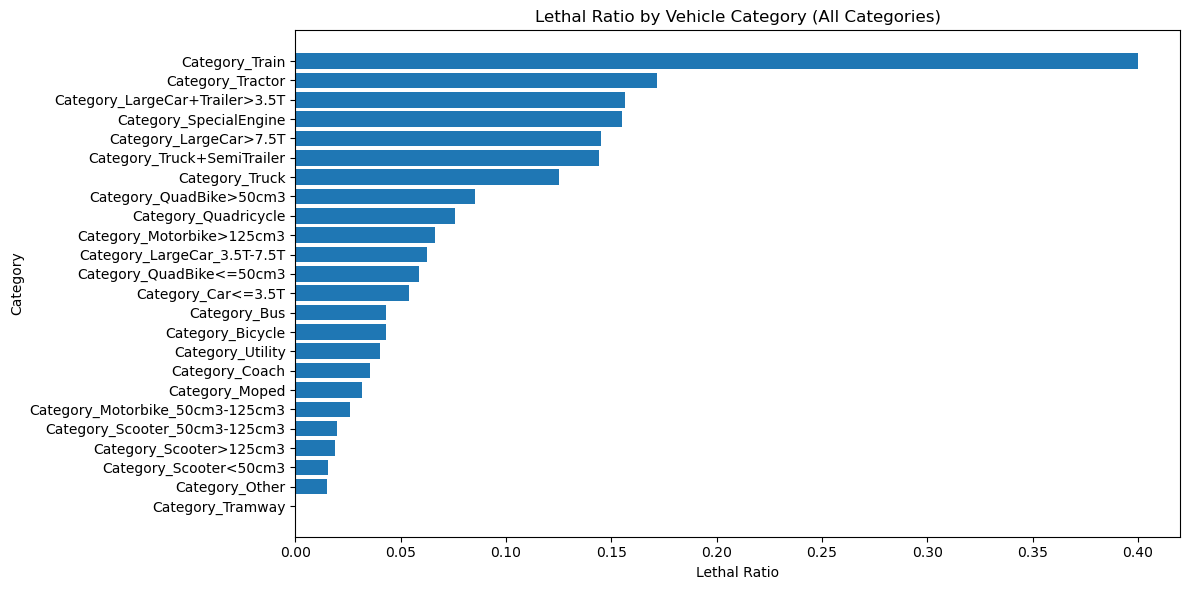

In [53]:
# 치명율 그래프
plot_df = category_gravity_ratio.sort_values("lethal_ratio", ascending=False)

plt.figure(figsize=(12, max(6, 0.25 * len(plot_df))))
plt.barh(plot_df.index, plot_df["lethal_ratio"])
plt.xlabel("Lethal Ratio")
plt.ylabel("Category")
plt.title("Lethal Ratio by Vehicle Category (All Categories)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

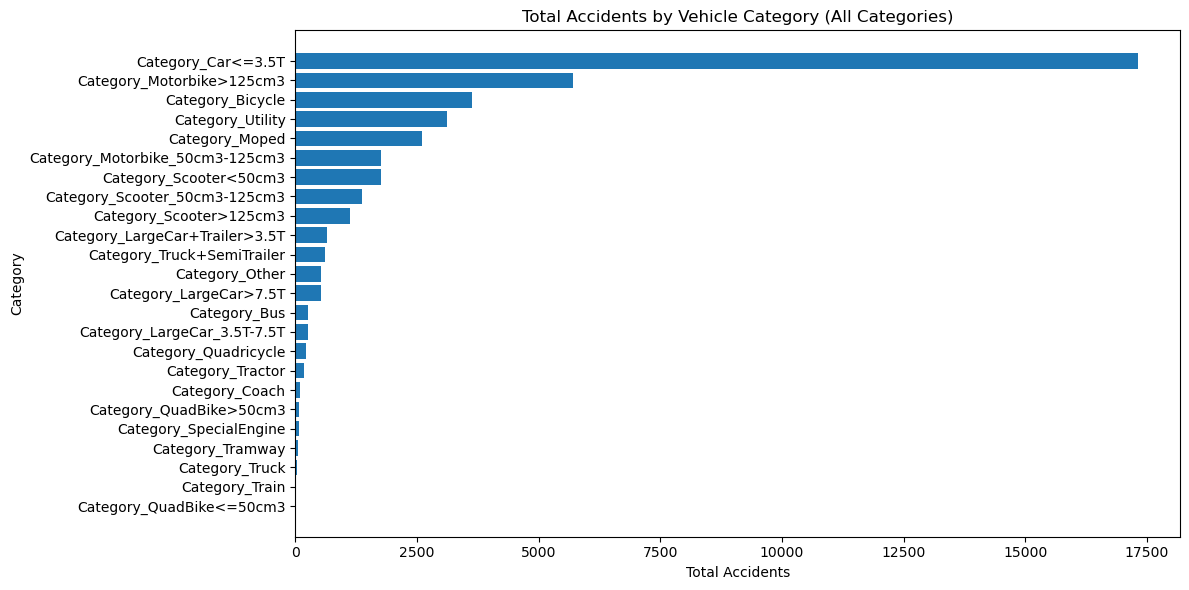

In [54]:
# 사고건수(total_accidents) 시각화
plot_df = category_gravity_ratio.sort_values("total_accidents", ascending=False)

plt.figure(figsize=(12, max(6, 0.25 * len(plot_df))))
plt.barh(plot_df.index, plot_df["total_accidents"])
plt.xlabel("Total Accidents")
plt.ylabel("Category")
plt.title("Total Accidents by Vehicle Category (All Categories)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

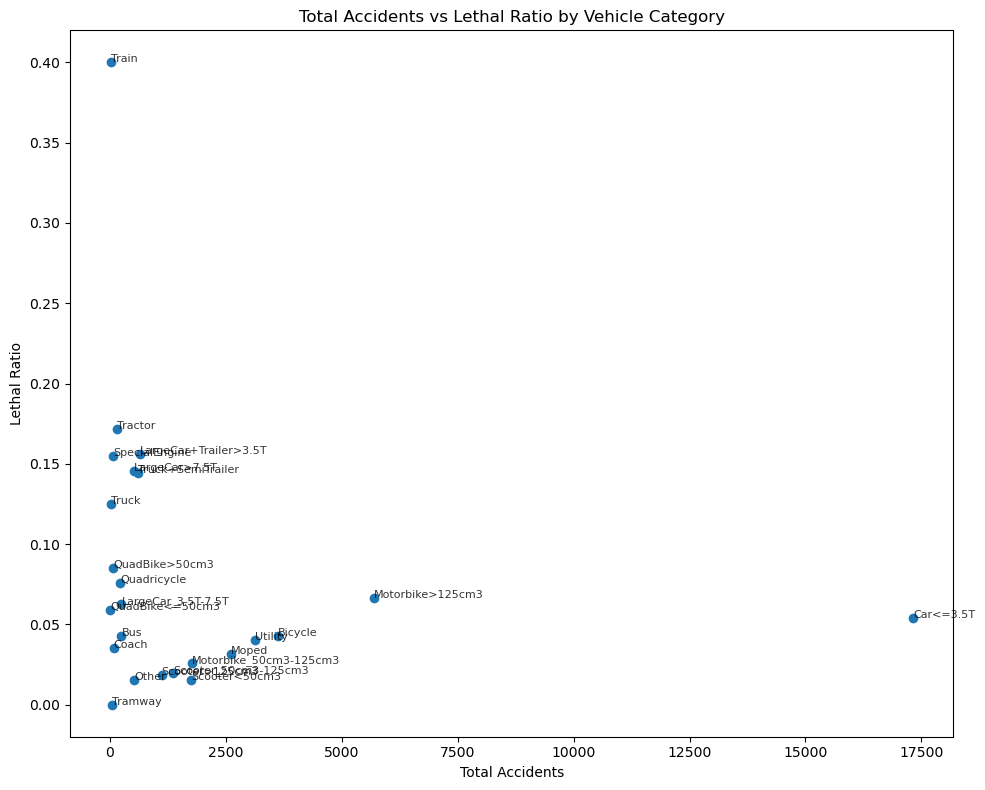

In [55]:
# 사고건수 vs 치명률 산점도
plot_df = category_gravity_ratio.copy()

plt.figure(figsize=(10, 8))
plt.scatter(plot_df["total_accidents"], plot_df["lethal_ratio"])

# 각 점에 Category 이름 붙이기
for cat, row in plot_df.iterrows():
    plt.text(
        row["total_accidents"],
        row["lethal_ratio"],
        cat.replace("Category_", ""),
        fontsize=8,
        alpha=0.8
    )

plt.xlabel("Total Accidents")
plt.ylabel("Lethal Ratio")
plt.title("Total Accidents vs Lethal Ratio by Vehicle Category")
plt.tight_layout()
plt.show()

## 2) Category_* 구간화 하기
 
기존의 차량 유형 멀티 인코딩은 범주가 과도하게 분산되어 모델이 위험 신호를 학습하는 데 한계가 있었다.    
이를 해결하기 위해 차량 유형을 사고 치명률 기반 위험 점수로 재구성하였고 해당 점수는 사고 심각도와의 관계를 서열 구조로 안정적으로 반영함을 확인하였다.

In [56]:
# 치명률 기준 구간화
category_bin_map = {
    # top_high
    "Category_Train": "top_high",

    # high
    "Category_Tractor": "high",
    "Category_LargeCar+Trailer>3.5T": "high",
    "Category_SpecialEngine": "high",
    "Category_LargeCar>7.5T": "high",
    "Category_Truck+SemiTrailer": "high",
    "Category_Truck": "high",

    # mid_high
    "Category_QuadBike>50cm3": "mid_high",
    "Category_Quadricycle": "mid_high",
    "Category_Motorbike>125cm3": "mid_high",
    "Category_LargeCar_3.5T-7.5T": "mid_high",
    "Category_QuadBike<=50cm3": "mid_high",

    # mid_low
    "Category_Car<=3.5T": "mid_low",
    "Category_Bus": "mid_low",
    "Category_Bicycle": "mid_low",
    "Category_Utility": "mid_low",
    "Category_Coach": "mid_low",
    "Category_Moped": "mid_low",

    # low
    "Category_Motorbike_50cm3-125cm3": "low",
    "Category_Scooter_50cm3-125cm3": "low",
    "Category_Scooter>125cm3": "low",
    "Category_Scooter<50cm3": "low",
    "Category_Other": "low",

    # top_low
    "Category_Tramway": "top_low"
}

In [57]:
# bin 컬럼 이름 bins 저장

bins = ["top_high", "high", "mid_high", "mid_low", "low", "top_low"]

# bin별로 포함되는 Category_* 컬럼 묶기

bin_to_cols = {
    b: [c for c, bb in category_bin_map.items() if bb == b and c in final_train.columns]
    for b in bins
}

# bin 컬럼 생성

for b, cols in bin_to_cols.items():
    final_train[f"has_category_{b}"] = (
        final_train[cols].fillna(0).astype(int).max(axis=1) if cols else 0
    )

In [58]:
# bin × Gravity 분석

category_bin_gravity_ratio = (
    final_train
    .assign(is_lethal=(final_train["Gravity"] == "Lethal").astype(int))
    .melt(
        id_vars=["is_lethal"],
        value_vars=[f"has_category_{b}" for b in bins],
        var_name="risk_bin",
        value_name="has_category"
    )
    .query("has_category == 1")
    .assign(risk_bin=lambda d: d["risk_bin"].str.replace("has_category_", "", regex=False))
    .groupby("risk_bin")["is_lethal"]
    .agg(total_accidents="count", lethal_ratio="mean")
    .sort_values("lethal_ratio", ascending=False)
)

category_bin_gravity_ratio

,total_accidents,lethal_ratio
risk_bin,,
top_high,20,0.400000
high,2007,0.150473
mid_high,6240,0.066827
mid_low,20139,0.054223
low,6406,0.020137
top_low,49,0.000000


### 위험 순위별 차량정보 컬럼 만들기

In [59]:
# 최대 위험 점수 만들기
# top_high > high > mid_high > mid_low > low > top_low

risk_score_map = {
    "has_category_top_high": 5,
    "has_category_high": 4,
    "has_category_mid_high": 3,
    "has_category_mid_low": 2,
    "has_category_low": 1,
    "has_category_top_low": 0
}

# 사고당 최대 위험 그룹 점수
risk_cols = list(risk_score_map.keys())

final_train["max_category_risk_score"] = (
    final_train[risk_cols]
    .fillna(0)
    .astype(int)
    .mul(pd.Series(risk_score_map))
    .max(axis=1)
)

In [60]:
# max_category_risk_score × Gravity

risk_score_gravity = (
    final_train
    .assign(is_lethal=(final_train["Gravity"] == "Lethal").astype(int))
    .groupby("max_category_risk_score")["is_lethal"]
    .agg(
        total_accidents="count",
        lethal_ratio="mean"
    )
    .sort_index(ascending=False)
)

In [61]:
# 라벨 붙여서 확인
score_label = {
    5: "top_high",
    4: "high",
    3: "mid_high",
    2: "mid_low",
    1: "low",
    0: "top_low"
}

risk_score_gravity_named = risk_score_gravity.rename(index=score_label)
risk_score_gravity_named

,total_accidents,lethal_ratio
max_category_risk_score,,
72,1,0.000000
60,1,0.000000
58,1,1.000000
56,3,0.333333
50,1,0.000000
44,1,0.000000
40,1,1.000000
34,3,0.000000
32,2,0.500000


### 차량 종류별 구간화

심각도 비율로 구간화 한 category_* 변수들을 이번에는 차량의 종류별로 묶어 구분을 진행한다.

In [62]:
# 차량별 구간화

vehicle_group_map = {
    "small_car": [
        "Category_Car<=3.5T",
        "Category_Utility"
    ],
    "mid_car": [
        "Category_Bus",
        "Category_Coach"
    ],
    "truck": [
        "Category_Truck",
        "Category_Truck+SemiTrailer",
        "Category_LargeCar_3.5T-7.5T",
        "Category_LargeCar>7.5T",
        "Category_LargeCar+Trailer>3.5T",
        "Category_Tractor"
    ],
    "two_wheel": [
        "Category_Bicycle",
        "Category_Moped",
        "Category_Motorbike>125cm3",
        "Category_Motorbike_50cm3-125cm3",
        "Category_Scooter<50cm3",
        "Category_Scooter_50cm3-125cm3",
        "Category_Scooter>125cm3"
    ],
    "special": [
        "Category_Train",
        "Category_Tramway",
        "Category_SpecialEngine",
        "Category_QuadBike<=50cm3",
        "Category_QuadBike>50cm3",
        "Category_Quadricycle"
    ],
    "other": [
        "Category_Other"
    ]
}

In [63]:
# 그룹별 원-핫 생성
for group, cols in vehicle_group_map.items():
    valid_cols = [c for c in cols if c in final_train.columns]
    final_train[f"has_vehicle_{group}"] = (
        final_train[valid_cols].fillna(0).sum(axis=1) > 0
    ).astype(int)

In [64]:
# 새로운 그룹 차량별 심각도 분석

vehicle_group_cols = [f"has_vehicle_{g}" for g in vehicle_group_map.keys()]

vehicle_group_gravity = (
    final_train
    .assign(is_lethal=(final_train["Gravity"] == "Lethal").astype(int))
    .melt(
        id_vars=["is_lethal"],
        value_vars=vehicle_group_cols,
        var_name="vehicle_group",
        value_name="has_group"
    )
    .query("has_group == 1")
    .groupby("vehicle_group")["is_lethal"]
    .agg(
        total_accidents="count",
        lethal_ratio="mean"
    )
    .sort_values("lethal_ratio", ascending=False)
)

vehicle_group_gravity

,total_accidents,lethal_ratio
vehicle_group,,
has_vehicle_truck,2574,0.152681
has_vehicle_special,717,0.087866
has_vehicle_small_car,39979,0.053753
has_vehicle_mid_car,687,0.050946
has_vehicle_two_wheel,20667,0.040983
has_vehicle_other,627,0.027113


### 차량 순위별 치명율 기준 그룹 생성

In [65]:
# 그룹 점수 정의

vehicle_group_score = {
    "has_vehicle_truck": 5,
    "has_vehicle_special": 4,
    "has_vehicle_small_car": 3,
    "has_vehicle_mid_car": 2,
    "has_vehicle_two_wheel": 1,
    "has_vehicle_other": 0
}

In [66]:
# max_vehicle_group_score 생성

vehicle_group_cols = list(vehicle_group_score.keys())

# 각 차량 그룹 컬럼이 1인 경우 해당 점수 부여
vehicle_group_scores = pd.DataFrame({
    col: final_train[col] * score
    for col, score in vehicle_group_score.items()
})

# 사고 단위 최대 차량 위험 점수
final_train["max_vehicle_group_score"] = vehicle_group_scores.max(axis=1)

In [67]:
# 심각도 분석
vehicle_group_gravity = (
    final_train
    .assign(is_lethal=(final_train["Gravity"] == "Lethal").astype(int))
    .groupby("max_vehicle_group_score")["is_lethal"]
    .agg(
        total_accidents="count",
        lethal_ratio="mean"
    )
    .sort_index(ascending=False)
)

In [68]:
# 라벨 붙여서 확인
score_label = {
    5: "truck",
    4: "special",
    3: "small_car",
    2: "mid_car",
    1: "two_wheel",
    0: "other"
}

vehicle_group_gravity_named = vehicle_group_gravity.rename(index=score_label)
vehicle_group_gravity_named

,total_accidents,lethal_ratio
max_vehicle_group_score,,
truck,2574,0.152681
special,694,0.086455
small_car,38105,0.049652
mid_car,363,0.038567
two_wheel,5908,0.048409
other,172,0.075581


## 3) 안전 장비 관련 변수 분석

안전 장비 관련 집계 변수와 사고 심각도(Gravity) 간 평균 비교를 수행한 결과    
Safety_used_no_count에서 Lethal과 NonLethal 사고 간 유의미한 차이가 확인되었다.

이는 사고에 안전벨트 미착용자가 포함되어 있는 경우 사고 심각도가 높아질 가능성이 있음을 시사한다.    
이에 따라 단순 인원 수(count) 정보뿐 아니라 안전벨트 미착용자 포함 여부를 명확히 구분하기 위해 has_safety_no 변수를 추가하였다.

In [69]:
# 안전 장비 변수 vs Gravity별 평균 비교

safety_cols = [
    "Safety_used_yes_count",
    "Safety_used_no_count",
    "Safety_used_unknown_count",
    "Safety_used_missing_count"
]

final_train.groupby("Gravity")[safety_cols].mean()

,Safety_used_yes_count,Safety_used_no_count,Safety_used_unknown_count,Safety_used_missing_count
Gravity,,,,
Lethal,1.740783,0.138450,0.182468,0.278029
NonLethal,1.787559,0.045531,0.167353,0.271193


In [70]:
# Safety_used_no_count 존재 여부 'has_safety_no' 생성
final_train["has_safety_no"] = (final_train["Safety_used_no_count"] > 0).astype(int)

## 4) 안전 장비 vs 나이 그룹 변수 분석

- 안전장비 변수는 단일 착용 여부가 아닌, 사고의 위험 맥락을 구분하기 위해 조건 조합 기반으로 재설계하였다.
- 안전벨트 미착용(`has_safety_no`)과 노년층 포함(`has_elder`)은 각각 단일 조건에서도 치명 사고 비율이 높아 기본 위험 신호로 유지하였다.
- 두 조건이 동시에 충족되는 경우 치명 사고 가능성이 더욱 뚜렷해져, 이를 명시적으로 반영한 `has_safety_no_elder` 변수를 추가하였다.
- 또한 미착용 치명 사고에서 성인 그룹이 가장 높은 포함 비율을 보여, 미착용 사고 내 주요 연령 구성을 구분하기 위해 `has_safety_no_adult` 변수를 생성하였다.
- 해당 변수들은 위험도를 단정하기보다, 치명 사고가 발생하는 구조적 유형을 분리하기 위한 목적에서 설계되었다.

### 빈도율

In [71]:
# 나이 그룹 × Gravity 빈도율

age_cols = [
    "Passenger_child",
    "Passenger_youth",
    "Passenger_adult",
    "Passenger_senior",
    "Passenger_elder",
    "Passenger_age_unknown"
]

final_train.groupby("Gravity")[age_cols].mean()

,Passenger_child,Passenger_youth,Passenger_adult,Passenger_senior,Passenger_elder,Passenger_age_unknown
Gravity,,,,,,
Lethal,0.058691,0.106095,0.127163,0.136193,0.156885,0.013168
NonLethal,0.041943,0.070312,0.087829,0.085504,0.090686,0.007862


In [72]:
# 안전벨트 미착용 사고 안에서의 나이 분포

# 미착용자 포함 사고 필터링
df_no = final_train[final_train["Safety_used_no_count"] > 0]

# 필터링 Gravity별 나이 빈도율
df_no.groupby("Gravity")[age_cols].mean()

,Passenger_child,Passenger_youth,Passenger_adult,Passenger_senior,Passenger_elder,Passenger_age_unknown
Gravity,,,,,,
Lethal,0.072414,0.227586,0.255172,0.196552,0.196552,0.010345
NonLethal,0.036116,0.129070,0.111308,0.121966,0.128478,0.012433


In [73]:
# 나이 그룹 포함 여부 컬럼 생성
age_cols = [
    "Passenger_child",
    "Passenger_youth",
    "Passenger_adult",
    "Passenger_senior",
    "Passenger_elder",
    "Passenger_age_unknown"
]

for col in age_cols:
    has_col = col.replace("Passenger_", "has_")
    final_train[has_col] = (final_train[col].fillna(0) > 0).astype(int)

### Lethal 사고 기준: 나이 그룹 포함 비율

In [74]:
# Lethal 사고 필터
df_lethal = final_train[final_train["Gravity"] == "Lethal"]

In [75]:
# Lethal 사고 내에서 age_group 포함 비율 계산

has_age_cols = ["has_child", "has_youth", "has_adult", "has_senior", "has_elder"]

out = []
for col in has_age_cols:
    ratio = df_lethal[col].mean()
    out.append({"age_group": col, "lethal_inclusion_ratio": ratio})

lethal_age_inclusion = (
    pd.DataFrame(out)
    .sort_values("lethal_inclusion_ratio", ascending=False)
    .reset_index(drop=True)
)

lethal_age_inclusion

,age_group,lethal_inclusion_ratio
0,has_elder,0.121896
1,has_senior,0.111738
2,has_adult,0.102333
3,has_youth,0.068473
4,has_child,0.040632


### 안전장비 미착용 및 착용 사고 중 Lethal 기준 나이 그룹 포함 비율

In [76]:
# 안전벨트 미착용 + Lethal 사고 필터
df_no_lethal = final_train[
    (final_train["Safety_used_no_count"] > 0) & (final_train["Gravity"] == "Lethal")]

In [77]:
# 나이 그룹별 lethal 비율 계산
has_age_cols = ["has_child", "has_youth", "has_adult", "has_senior", "has_elder"]

out = []
for col in has_age_cols:
    ratio = df_no_lethal[col].mean()
    out.append({
        "age_group": col,
        "no_safety_lethal_inclusion_ratio": ratio
    })

no_safety_lethal_age_inclusion = (
    pd.DataFrame(out)
    .sort_values("no_safety_lethal_inclusion_ratio", ascending=False)
    .reset_index(drop=True)
)

no_safety_lethal_age_inclusion

,age_group,no_safety_lethal_inclusion_ratio
0,has_adult,0.155172
1,has_elder,0.141379
2,has_senior,0.131034
3,has_youth,0.124138
4,has_child,0.055172


In [78]:
# 미착용 + NonLethal 사고 기준 동일 비교
# 안전벨트 미착용 + NonLethal 사고 필터
df_no_nonlethal = final_train[
    (final_train["Safety_used_no_count"] > 0) & (final_train["Gravity"] == "NonLethal")]

In [79]:
# 미착용 + NonLethal 사고 기준 나이 그룹 포함 비율 계산
has_age_cols = ["has_child", "has_youth", "has_adult", "has_senior", "has_elder"]

out = []
for col in has_age_cols:
    ratio = df_no_nonlethal[col].mean()
    out.append({
        "age_group": col,
        "no_safety_nonlethal_inclusion_ratio": ratio
    })

no_safety_nonlethal_age_inclusion = (
    pd.DataFrame(out)
    .sort_values("no_safety_nonlethal_inclusion_ratio", ascending=False)
    .reset_index(drop=True)
)

no_safety_nonlethal_age_inclusion

,age_group,no_safety_nonlethal_inclusion_ratio
0,has_elder,0.098875
1,has_senior,0.089402
2,has_adult,0.086442
3,has_youth,0.081113
4,has_child,0.030195


In [80]:
# 안전장비 미착용한 elder 그룹 변수 생성
final_train["has_safety_no_elder"] = (
    (final_train["Safety_used_no_count"] > 0) & (final_train["has_elder"] == 1)).astype(int)

In [81]:
# 안전장비 미착용한 adult 그룹 변수 생성
final_train["has_safety_no_adult"] = (
    (final_train["Safety_used_no_count"] > 0) &(final_train["has_adult"] == 1)).astype(int)

## 4) 충돌 구조물 변수 분석

## CollisionType 컬럼 분석

CollisionType은 사고의 충돌 형태를 타나내는 핵심 상황 변수이다.

사고 심각도와 연관을 확인하기 위해 CollisionType별 Lethal 비율(lethal_ratio) 과 전체 사고에서의 발생 비율(overall_ratio) 을 함께 비교했다.    
분석 결과 CollisionType에 따라 Lethal 비율이 뚜렷하게 달라졌으며 특히 정면 충돌 성격의 유형과 다중 충돌은 상대적으로 높은 치명 비율을 보였다.    
반면 측면, 일반 추돌은 발생 비율은 높지만 치명 비율은 낮아 빈도와 위험도가 분리되는 패턴이 확인되었다.

CollisionType은 사고 심각도를 설명하는 구조적 신호로 의미가 있으며, 모델이 충돌 상황의 차이를 직접 학습할 수 있도록 원본 범주 값을 유지해 활용한다.

In [82]:
# CollisionType 기준 Lethal 비율

collision_gravity_summary = (
    final_train
    .assign(is_lethal=(final_train["Gravity"] == "Lethal").astype(int))
    .groupby("CollisionType")
    .agg(
        total_cnt=("Gravity", "count"),
        lethal_cnt=("is_lethal", "sum")
    )
    .assign(
        lethal_ratio=lambda x: x["lethal_cnt"] / x["total_cnt"]
    )
    .sort_values("lethal_ratio", ascending=False)
)

collision_gravity_summary

,total_cnt,lethal_cnt,lethal_ratio
CollisionType,,,
2Vehicles-BehindVehicles-Frontal,4274,502,0.117454
3+Vehicles-Multiple,1569,141,0.089866
Other,16159,1163,0.071972
NoCollision,4333,288,0.066467
2Vehicles-Side,13462,370,0.027485
2Vehicles-Behind,6139,151,0.024597
3+Vehicles-Chain,1880,43,0.022872


In [83]:
# 전체 사고 기준 CollisionType 발생 비율

collision_gravity_overall_ratio = (
    final_train["CollisionType"]
    .value_counts(normalize=True)
    .rename("overall_ratio(전체사고 기준 발생 비율)")
)

collision_gravity_summary = collision_gravity_summary.join(
    collision_gravity_overall_ratio
)

collision_gravity_summary

,total_cnt,lethal_cnt,lethal_ratio,overall_ratio(전체사고 기준 발생 비율)
CollisionType,,,,
2Vehicles-BehindVehicles-Frontal,4274,502,0.117454,0.089384
3+Vehicles-Multiple,1569,141,0.089866,0.032813
Other,16159,1163,0.071972,0.337941
NoCollision,4333,288,0.066467,0.090618
2Vehicles-Side,13462,370,0.027485,0.281538
2Vehicles-Behind,6139,151,0.024597,0.128388
3+Vehicles-Chain,1880,43,0.022872,0.039317


## FixedObstacle 컬럼 분석

FixedObstacle은 사고 시 차량이 고정 구조물과 충돌했는지 그리고 어떤 구조물과 충돌했는지를 나타내는 변수이다.

각 구조물 유형은 원-핫 형태의 개별 컬럼으로 제공되며 유형별 Lethal 비율을 비교해보면      
Tree, Post, Ditch/RockyWall, BuildingWall/Pier 등 특정 고정 구조물과의 충돌에서 치명 사고 비율이 상대적으로 높게 나타났다.    
반면 ConcreteBarrier, StreetFurniture, StationaryVehicle 등은 치명 비율이 낮아 구조물 종류에 따라 위험도가 단계적으로 구분되는 패턴이 확인되었다.

다만 FixedObstacle_Missing의 비중이 매우 높았으며 대부분의 CollisionType에서 Missing 비율이 95% 이상으로 나타났다.
이런 현상은 고정 구조물과 충돌하지 않은것으로 보기보단 고정 구조물 세부 정보가 기록되지 않은 경우가 다수 포함된 상태로 해석하는 것이 합리적이라고 판단했다.
Missing 여부는 정보 부재 자체를 나타내는 신호로 분리해 다루는 것이 필요하다고 판단했다.

FixedObstacle 원본 컬럼은 개수가 많고 희소성이 높아 그대로 모두 사용할 경우 모델 복잡도가 증가할 수 있다고 판단해     
구조물별 lethal_ratio를 기준으로 위험도를 단계화하여 그룹 기반 파생 변수를 생성했다.

- has_fixed_obstacle_any : 고정 구조물 충돌이 하나라도 발생했는지 여부
- has_fixed_obstacle_missing : 고정 구조물 정보가 기록되지 않은 사고 여부
- 험도 기반 그룹 플래그 :
  - has_fixed_obstacle_top_high
  - has_fixed_obstacle_high
  - has_fixed_obstacle_mid
  - has_fixed_obstacle_mid_small
  - has_fixed_obstacle_small
  - has_fixed_obstacle_xsmall


위의 파생 변수중 개별 FixedObstacle_* 원본 컬럼을 사용하지 않고 위 컬럼들을 사용하는 것으로 활용했다.

In [84]:
# FixedObstacle 컬럼 리스트
fixed_cols = [
    'FixedObstacle_BuildingWallOrPier',
    'FixedObstacle_ConcreteBarrier',
    'FixedObstacle_DitchTalusOrRockyWall',
    'FixedObstacle_ExitLaneWithoutObstacle',
    'FixedObstacle_MetallicBarrier',
    'FixedObstacle_Missing',
    'FixedObstacle_OtherBarrier',
    'FixedObstacle_OtherInLane',
    'FixedObstacle_OtherInSidewalkOrShoulder',
    'FixedObstacle_Parapet',
    'FixedObstacle_Post',
    'FixedObstacle_SideWalkEdge',
    'FixedObstacle_StationaryVehicle',
    'FixedObstacle_StreetFurniture',
    'FixedObstacle_TrafficIslandRefugeOrMilestone',
    'FixedObstacle_TrafficSignOrEmergencyBox',
    'FixedObstacle_Tree',
]

In [85]:
# FixedObstacle 기준 심각도 비율

fixed_obstacle_gravity_summary = (
    pd.concat(
        [
            final_train
            .loc[final_train[c] == 1, ["Gravity"]]
            .assign(FixedObstacle=c)
            for c in fixed_cols if c in final_train.columns
        ]
    )
    .assign(
        is_lethal=lambda x: (x["Gravity"] == "Lethal").astype(int),
        is_nonlethal=lambda x: (x["Gravity"] == "NonLethal").astype(int)
    )
    .groupby("FixedObstacle")
    .agg(
        total_cnt=("Gravity", "count"),
        lethal_cnt=("is_lethal", "sum"),
        nonlethal_cnt=("is_nonlethal", "sum")
    )
    .assign(
        lethal_ratio=lambda x: x["lethal_cnt"] / x["total_cnt"],
        nonlethal_ratio=lambda x: x["nonlethal_cnt"] / x["total_cnt"]
    )
    .sort_values("lethal_ratio", ascending=False)
)

fixed_obstacle_gravity_summary

,total_cnt,lethal_cnt,nonlethal_cnt,lethal_ratio,nonlethal_ratio
FixedObstacle,,,,,
FixedObstacle_Tree,1238,242,996,0.195477,0.804523
FixedObstacle_Post,851,110,741,0.129260,0.870740
FixedObstacle_DitchTalusOrRockyWall,1516,187,1329,0.123351,0.876649
FixedObstacle_BuildingWallOrPier,955,114,841,0.119372,0.880628
FixedObstacle_OtherBarrier,126,15,111,0.119048,0.880952
FixedObstacle_MetallicBarrier,940,93,847,0.098936,0.901064
FixedObstacle_TrafficSignOrEmergencyBox,248,24,224,0.096774,0.903226
FixedObstacle_OtherInSidewalkOrShoulder,459,44,415,0.095861,0.904139
FixedObstacle_ExitLaneWithoutObstacle,391,37,354,0.094629,0.905371


### CollisionType × FixedObstacle_Missing 분석

In [86]:
# FixedObstacle Missing 존재 여부 플래그 생성
final_train["has_fixed_obstacle_missing"] = (final_train["FixedObstacle_Missing"] > 0).astype(int)

In [87]:
# CollisionType × FixedObstacle_Missing 교차 분포
collision_fixed_missing_ct = (
    final_train
    .groupby(["CollisionType", "has_fixed_obstacle_missing"])
    .size()
    .unstack(fill_value=0)
)

collision_fixed_missing_ct

has_fixed_obstacle_missing,0,1
CollisionType,,
2Vehicles-Behind,123,6016
2Vehicles-BehindVehicles-Frontal,66,4208
2Vehicles-Side,173,13289
3+Vehicles-Chain,19,1861
3+Vehicles-Multiple,23,1546
NoCollision,1728,2605
Other,6214,9945


In [88]:
# CollisionType 내부 비율

collision_fixed_missing_ratio = (
    collision_fixed_missing_ct
    .div(collision_fixed_missing_ct.sum(axis=1), axis=0)
)

collision_fixed_missing_ratio

has_fixed_obstacle_missing,0,1
CollisionType,,
2Vehicles-Behind,0.020036,0.979964
2Vehicles-BehindVehicles-Frontal,0.015442,0.984558
2Vehicles-Side,0.012851,0.987149
3+Vehicles-Chain,0.010106,0.989894
3+Vehicles-Multiple,0.014659,0.985341
NoCollision,0.398800,0.601200
Other,0.384553,0.615447


In [89]:
# NoCollision + Other 필터 후 FixedObstacle lethal_ratio
# 필터링
target_df = final_train[final_train["CollisionType"].isin(["NoCollision", "Other"])]

In [90]:
# FixedObstacle 기준 (NoCollision + Other) lethal / nonlethal 비율

fixed_obstacle_gravity_summary_nc_other = (
    pd.concat(
        [
            target_df
            .loc[target_df[c] == 1, ["Gravity"]]
            .assign(FixedObstacle=c)
            for c in fixed_cols if c in target_df.columns
        ]
    )
    .assign(
        is_lethal=lambda x: (x["Gravity"] == "Lethal").astype(int),
        is_nonlethal=lambda x: (x["Gravity"] == "NonLethal").astype(int)
    )
    .groupby("FixedObstacle")
    .agg(
        total_cnt=("Gravity", "count"),
        lethal_cnt=("is_lethal", "sum"),
        nonlethal_cnt=("is_nonlethal", "sum")
    )
    .assign(
        lethal_ratio=lambda x: x["lethal_cnt"] / x["total_cnt"],
        nonlethal_ratio=lambda x: x["nonlethal_cnt"] / x["total_cnt"]
    )
    .sort_values("lethal_ratio", ascending=False)
)

fixed_obstacle_gravity_summary_nc_other

,total_cnt,lethal_cnt,nonlethal_cnt,lethal_ratio,nonlethal_ratio
FixedObstacle,,,,,
FixedObstacle_Tree,1141,227,914,0.198948,0.801052
FixedObstacle_OtherBarrier,102,15,87,0.147059,0.852941
FixedObstacle_Post,647,94,553,0.145286,0.854714
FixedObstacle_BuildingWallOrPier,808,107,701,0.132426,0.867574
FixedObstacle_DitchTalusOrRockyWall,1355,164,1191,0.121033,0.878967
FixedObstacle_OtherInSidewalkOrShoulder,367,40,327,0.108992,0.891008
FixedObstacle_TrafficSignOrEmergencyBox,167,18,149,0.107784,0.892216
FixedObstacle_ExitLaneWithoutObstacle,331,34,297,0.102719,0.897281
FixedObstacle_MetallicBarrier,637,57,580,0.089482,0.910518


In [91]:
# 이전 결과와 지금 결과를 직접 비교하는 테이블

compare_df = (
    fixed_obstacle_gravity_summary
    .rename(columns={
        "lethal_ratio": "lethal_ratio_all"
    })[["lethal_ratio_all"]]
    .join(
        fixed_obstacle_gravity_summary_nc_other[["lethal_ratio"]]
        .rename(columns={"lethal_ratio": "lethal_ratio_nc_other"})
    )
    .assign(
        diff=lambda x: x["lethal_ratio_nc_other"] - x["lethal_ratio_all"]
    )
    .sort_values("diff", ascending=False)
)

compare_df

,lethal_ratio_all,lethal_ratio_nc_other,diff
FixedObstacle,,,
FixedObstacle_OtherBarrier,0.119048,0.147059,0.028011
FixedObstacle_Post,0.129260,0.145286,0.016026
FixedObstacle_Parapet,0.060976,0.074627,0.013651
FixedObstacle_OtherInSidewalkOrShoulder,0.095861,0.108992,0.013131
FixedObstacle_BuildingWallOrPier,0.119372,0.132426,0.013054
FixedObstacle_TrafficSignOrEmergencyBox,0.096774,0.107784,0.011010
FixedObstacle_ExitLaneWithoutObstacle,0.094629,0.102719,0.008090
FixedObstacle_SideWalkEdge,0.062370,0.069948,0.007578
FixedObstacle_Tree,0.195477,0.198948,0.003472


In [92]:
# 구조물 충돌 여부 컬럼 생성
fixed_obstacle_cols = [c for c in final_train.columns 
                       if c.startswith("FixedObstacle_") and c != "FixedObstacle_Missing"]

final_train["has_fixed_obstacle_any"] = (final_train[fixed_obstacle_cols].fillna(0).astype(int).max(axis=1))

### 구조물 충돌 포함 여부에 따른 그룹화

In [93]:
# FixedObstacle 충돌 유형 포함 여부 컬럼 생성

#FixedObstacle_* 컬럼 전체 선택
fixed_cols = [c for c in final_train.columns if c.startswith("FixedObstacle_")]

# count를 존재 여부(0/1) 이진화
final_train[fixed_cols] = (
    final_train[fixed_cols]
    .fillna(0)
    .gt(0)
    .astype(int)
)

In [94]:
# FixedObstacle 포함 여부 lethal_ratio
fixed_cols = [c for c in final_train.columns if c.startswith("FixedObstacle_")]
fixed_cols = [c for c in fixed_cols if c != "FixedObstacle_Missing"]  # Missing 제외

fixed_obstacle_lethal_ratio = (
    pd.concat(
        [
            final_train
            .loc[final_train[c] == 1, ["Gravity"]]
            .assign(FixedObstacle=c)
            for c in fixed_cols
        ],
        ignore_index=True
    )
    .assign(is_lethal=lambda x: (x["Gravity"] == "Lethal").astype(int))
    .groupby("FixedObstacle")
    .agg(
        total_cnt=("Gravity", "count"),
        lethal_cnt=("is_lethal", "sum")
    )
    .assign(lethal_ratio=lambda x: x["lethal_cnt"] / x["total_cnt"])
    .sort_values("lethal_ratio", ascending=False)
)

fixed_obstacle_lethal_ratio

,total_cnt,lethal_cnt,lethal_ratio
FixedObstacle,,,
FixedObstacle_Tree,1248,242,0.193910
FixedObstacle_Post,865,111,0.128324
FixedObstacle_OtherBarrier,129,16,0.124031
FixedObstacle_DitchTalusOrRockyWall,1550,192,0.123871
FixedObstacle_BuildingWallOrPier,965,114,0.118135
FixedObstacle_MetallicBarrier,1010,103,0.101980
FixedObstacle_OtherInSidewalkOrShoulder,463,44,0.095032
FixedObstacle_TrafficSignOrEmergencyBox,256,24,0.093750
FixedObstacle_ExitLaneWithoutObstacle,398,37,0.092965


In [95]:
# 그룹 매핑 코드

fixed_obstacle_groups = {
    "top_high": [
        "FixedObstacle_Tree"
    ],
    "high": [
        "FixedObstacle_Post",
        "FixedObstacle_OtherBarrier",
        "FixedObstacle_DitchTalusOrRockyWall",
        "FixedObstacle_BuildingWallOrPier"
    ],
    "mid": [
        "FixedObstacle_MetallicBarrier",
        "FixedObstacle_OtherInSidewalkOrShoulder",
        "FixedObstacle_TrafficSignOrEmergencyBox",
        "FixedObstacle_ExitLaneWithoutObstacle"
    ],
    "mid_small": [
        "FixedObstacle_TrafficIslandRefugeOrMilestone"
    ],
    "small": [
        "FixedObstacle_SideWalkEdge",
        "FixedObstacle_Parapet",
        "FixedObstacle_OtherInLane"
    ],
    "xsmall": [
        "FixedObstacle_StationaryVehicle",
        "FixedObstacle_ConcreteBarrier",
        "FixedObstacle_StreetFurniture"
    ]
}

In [96]:
# 그룹 플래그 생성
for group, cols in fixed_obstacle_groups.items():
    cols_in_df = [c for c in cols if c in final_train.columns]
    
    final_train[f"has_fixed_obstacle_{group}"] = (final_train[cols_in_df].max(axis=1) if cols_in_df else 0)

In [97]:
group_cols = ["has_fixed_obstacle_top_high", "has_fixed_obstacle_high", "has_fixed_obstacle_mid", 
       "has_fixed_obstacle_mid_small", "has_fixed_obstacle_small", "has_fixed_obstacle_xsmall"]

In [98]:
# 생성 확인
final_train[group_cols]

,has_fixed_obstacle_top_high,has_fixed_obstacle_high,has_fixed_obstacle_mid,has_fixed_obstacle_mid_small,has_fixed_obstacle_small,has_fixed_obstacle_xsmall
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,1
3,0,0,0,0,0,0
4,0,0,0,0,0,0
...,...,...,...,...,...,...
47811,0,0,0,0,0,0
47812,0,0,0,0,0,0
47813,0,0,0,0,0,0
47814,0,0,0,0,0,0


In [99]:
# "개별 FixedObstacle 기준” vs “그룹화 플래그 기준” Lethal / NonLethal 분포(카운트 + 비율) 

group_severity_summary = (
    pd.concat(
        [
            final_train.loc[final_train[c] == 1, ["Gravity"]]
            .assign(group=c)
            for c in group_cols
        ],
        ignore_index=True
    )
    .assign(
        is_lethal=lambda x: (x["Gravity"] == "Lethal").astype(int),
        is_nonlethal=lambda x: (x["Gravity"] == "NonLethal").astype(int),
    )
    .groupby("group")
    .agg(
        total_cnt=("Gravity", "count"),
        lethal_cnt=("is_lethal", "sum"),
        nonlethal_cnt=("is_nonlethal", "sum"),
    )
    .assign(
        lethal_ratio=lambda x: x["lethal_cnt"] / x["total_cnt"],
        nonlethal_ratio=lambda x: x["nonlethal_cnt"] / x["total_cnt"],
    )
    .sort_values("lethal_ratio", ascending=False)
)

group_severity_summary

,total_cnt,lethal_cnt,nonlethal_cnt,lethal_ratio,nonlethal_ratio
group,,,,,
has_fixed_obstacle_top_high,1248,242,1006,0.193910,0.806090
has_fixed_obstacle_high,3505,432,3073,0.123252,0.876748
has_fixed_obstacle_mid,2121,208,1913,0.098067,0.901933
has_fixed_obstacle_mid_small,164,13,151,0.079268,0.920732
has_fixed_obstacle_small,1130,67,1063,0.059292,0.940708
has_fixed_obstacle_xsmall,3080,141,2939,0.045779,0.954221


## MobileObstacle 컬럼 분석

MobileObstacle은 사고 당시 이동 중인 대상과의 충돌 여부를 나타내는 변수로 보행자, 차량, 동물 등 유형별로 count 형태로 제공된다.    
분석에서는 MobileObstacle이 사고 심각도를 단독으로 설명하는지, CollisionType 또는 다른 충돌 변수에 보조 정보인지를 확인하는 데 초점을 두었다.

**MobileObstacle별 Lethal 비율**은 RailedVehicle, Other에서 상대적 높은 치명 비율이 관찰되었으나 표본 수가 작아 단독 위험 신호로 일반화하기는 어렵다.    
반면 Vehicle 유형은 대부분의 사고에 포함되며 치명 비율이 낮아 위험 요인이라기보다 사고 상황에 기본적으로 동반되는 요소에 가깝다.    
MobileObstacle은 유형별 특성은 존재하지만 사고 심각도를 단독으로 설명하기에는 제한적인 변수로 판단하였다. 

**CollisionType별 MobileObstacle 포함 비율**은 NoCollision 사고에서는 대부분 MobileObstacle 정보가 기록되지 않고,    
반면 차량 간 충돌 유형에서는 MobileObstacle 포함 비율이 매우 높았다.    
MobileObstacle 변수가 사고 심각도를 직접 구분하기보다는 CollisionType이 결정된 이후에 따라오는 구조적 정보일 가능성이 높다는 점을 시사한다.
MobileObstacle 전체 포함 여부(has_mobile_obstacle_any)는 범위가 넓어 CollisionType과 중복성이 있어 단독 변수로 분별력이 제한적일 것으로 판단하였다.

MobileObstacle의 보행자 관련 정보는 이미 Users 집계 변수에서 별도로 생성된 보행자 포함 여부 변수가 존재한다.
이에 따라 MobileObstacle의 보행자 변수는 중복 정보 제공 가능성이 높아 최종 모델 입력 변수에서는 제외하였다.    
MobileObstacle은 단독 위험 변수로 사용하지 않고 충돌 상황을 보조적으로 설명하는 역할로 제한하여 활용하였다.

최종 사용 변수
* has_mobile_vehicle
* has_mobile_wild_animal
* has_mobile_domestic_animal
* has_mobile_other
* has_mobile_railed_vehicle
* has_mobile_missing

In [100]:
# MobileObstacle 컬럼 준비 + 이진화 컬럼 생성

mobile_cols = [
    "MobileObstacle_DomesticAnimal",
    "MobileObstacle_Missing",
    "MobileObstacle_Other",
    "MobileObstacle_Pedestrian",
    "MobileObstacle_RailedVehicle",
    "MobileObstacle_Vehicle",
    "MobileObstacle_WildAnimal",
]

mobile_cols = [c for c in mobile_cols if c in final_train.columns]

# 결측치만 0으로 (count 유지)
final_train[mobile_cols] = final_train[mobile_cols].fillna(0)

In [101]:
# MobileObstacle 이진 플래그 생성
final_train["has_mobile_domestic_animal"] = (final_train["MobileObstacle_DomesticAnimal"] > 0).astype(int)
final_train["has_mobile_other"] = (final_train["MobileObstacle_Other"] > 0).astype(int)
final_train["has_mobile_railed_vehicle"] = (final_train["MobileObstacle_RailedVehicle"] > 0).astype(int)
final_train["has_mobile_vehicle"] = (final_train["MobileObstacle_Vehicle"] > 0).astype(int)
final_train["has_mobile_wild_animal"] = (final_train["MobileObstacle_WildAnimal"] > 0).astype(int)
final_train["has_mobile_pedestrian"] = (final_train["MobileObstacle_Pedestrian"] > 0).astype(int)

In [102]:
# 상태 플래그 생성 
final_train["has_mobile_missing"] = (final_train["MobileObstacle_Missing"] > 0).astype(int)

### MobileObstacle 유형별 사고 심각도 분포 분석

In [103]:
# MobileObstacle 이진 플래그 컬럼 목록 (Missing 제외)

mobile_cols = [
    "MobileObstacle_DomesticAnimal",
    "MobileObstacle_Missing",
    "MobileObstacle_Other",
    "MobileObstacle_Pedestrian",
    "MobileObstacle_RailedVehicle",
    "MobileObstacle_Vehicle",
    "MobileObstacle_WildAnimal",
]

In [104]:
# 실제 존재하는 컬럼만 사용
mobile_cols = [c for c in mobile_cols if c in final_train.columns]

In [105]:
# 결측치만 0으로 (count 유지)
final_train[mobile_cols] = final_train[mobile_cols].fillna(0)

In [106]:
# has_ 이진 플래그 생성 (원본 count는 그대로 둠)
final_train["has_mobile_domestic_animal"] = (final_train["MobileObstacle_DomesticAnimal"] > 0).astype(int)
final_train["has_mobile_other"] = (final_train["MobileObstacle_Other"] > 0).astype(int)
final_train["has_mobile_railed_vehicle"] = (final_train["MobileObstacle_RailedVehicle"] > 0).astype(int)
final_train["has_mobile_vehicle"] = (final_train["MobileObstacle_Vehicle"] > 0).astype(int)
final_train["has_mobile_wild_animal"] = (final_train["MobileObstacle_WildAnimal"] > 0).astype(int)
final_train["has_mobile_pedestrian"] = (final_train["MobileObstacle_Pedestrian"] > 0).astype(int)

In [107]:
# 상태 플래그
final_train["has_mobile_missing"] = (final_train["MobileObstacle_Missing"] > 0).astype(int)

In [108]:
mobile_non_missing_cols = [
    "has_mobile_domestic_animal",
    "has_mobile_other",
    "has_mobile_pedestrian",
    "has_mobile_railed_vehicle",
    "has_mobile_vehicle",
    "has_mobile_wild_animal",
]
mobile_non_missing_cols = [c for c in mobile_non_missing_cols if c in final_train.columns]

# MobileObstacle 포함 여부(any) 상위 플래그
final_train["has_mobile_obstacle_any"] = (
    final_train[mobile_non_missing_cols].max(axis=1) if mobile_non_missing_cols else 0)

In [109]:
# 각 MobileObstacle 유형별 기준 사고 심각도(Lethal / NonLethal) 비율 확인

mobile_gravity_summary = (
    pd.concat(
        [
            final_train.loc[final_train[c] == 1, ["Gravity"]].assign(MobileObstacle=c)
            for c in mobile_non_missing_cols
        ],
        ignore_index=True
    )
    .assign(
        is_lethal=lambda x: (x["Gravity"] == "Lethal").astype(int),
        is_nonlethal=lambda x: (x["Gravity"] == "NonLethal").astype(int),
    )
    .groupby("MobileObstacle")
    .agg(
        total_cnt=("Gravity", "count"),
        lethal_cnt=("is_lethal", "sum"),
        nonlethal_cnt=("is_nonlethal", "sum"),
    )
    .assign(
        lethal_ratio=lambda x: x["lethal_cnt"] / x["total_cnt"],
        nonlethal_ratio=lambda x: x["nonlethal_cnt"] / x["total_cnt"],
    )
    .sort_values("lethal_ratio", ascending=False)
)

display(mobile_gravity_summary)

,total_cnt,lethal_cnt,nonlethal_cnt,lethal_ratio,nonlethal_ratio
MobileObstacle,,,,,
has_mobile_railed_vehicle,83,8,75,0.096386,0.903614
has_mobile_other,791,73,718,0.092288,0.907712
has_mobile_pedestrian,8387,415,7972,0.049481,0.950519
has_mobile_vehicle,28569,1220,27349,0.042704,0.957296
has_mobile_wild_animal,525,18,507,0.034286,0.965714
has_mobile_domestic_animal,67,1,66,0.014925,0.985075


### CollisionType별 MobileObstacle 포함 여부 분석

In [110]:
# CollisionType별 MovileObstacle이 포함 여부의 비율 분포
collision_x_mobile = (
    final_train
    .groupby(["CollisionType", "has_mobile_obstacle_any"])
    .size()
    .unstack(fill_value=0)
)

collision_x_mobile_ratio = collision_x_mobile.div(collision_x_mobile.sum(axis=1), axis=0)
display(collision_x_mobile_ratio)

has_mobile_obstacle_any,0,1
CollisionType,,
2Vehicles-Behind,0.023945,0.976055
2Vehicles-BehindVehicles-Frontal,0.019654,0.980346
2Vehicles-Side,0.012851,0.987149
3+Vehicles-Chain,0.017021,0.982979
3+Vehicles-Multiple,0.011472,0.988528
NoCollision,0.915994,0.084006
Other,0.381459,0.618541


In [111]:
# is_nocollision_no_mobile 파생 변수 생성

* has_mobile_obstacle_any는 정보가 너무 넓게 잡혀서 분별력이 약할 수 있음

### CollisionType × MobileObstacle 조합에 따른 사고 심각도 분석

In [112]:
# 충돌 유형과 이동 장애물 유형의 조합에 따른 사고 심각도 비율 분석

mobile_by_collision_lethal = (
    final_train
    .assign(is_lethal=(final_train["Gravity"] == "Lethal").astype(int))
    .melt(
        id_vars=["CollisionType", "is_lethal"],
        value_vars=mobile_non_missing_cols,
        var_name="MobileObstacle",
        value_name="flag"
    )
    .query("flag == 1")
    .groupby(["CollisionType", "MobileObstacle"])
    .agg(total_cnt=("is_lethal", "count"), lethal_cnt=("is_lethal", "sum"))
    .assign(lethal_ratio=lambda x: x["lethal_cnt"] / x["total_cnt"])
    .sort_values(["lethal_ratio", "total_cnt"], ascending=[False, False])
)

display(mobile_by_collision_lethal)

total_cnt  \
CollisionType                    MobileObstacle                          
3+Vehicles-Chain                 has_mobile_railed_vehicle           1   
2Vehicles-BehindVehicles-Frontal has_mobile_pedestrian              18   
3+Vehicles-Multiple              has_mobile_pedestrian               9   
                                 has_mobile_other                   47   
3+Vehicles-Chain                 has_mobile_other                   32   
2Vehicles-BehindVehicles-Frontal has_mobile_railed_vehicle           6   
                                 has_mobile_vehicle               4161   
3+Vehicles-Multiple              has_mobile_wild_animal             27   
2Vehicles-BehindVehicles-Frontal has_mobile_other                  119   
2Vehicles-Side                   has_mobile_railed_vehicle          66   
3+Vehicles-Multiple              has_mobile_vehicle               1545   
2Vehicles-Behind                 has_mobile_other                  113   
Other                            has_mobile_other                  116   
NoCollision                      has_mobile_other                   39   
Other                            has_mobile_wild_animal            140   
2Vehicles-BehindVehicles-Frontal has_mobile_wild_animal             35   
NoCollision                      has_mobile_pedestrian             128   
2Vehicles-Side                   has_mobile_other                  325   
Other                            has_mobile_pedestrian            8174   
NoCollision                      has_mobile_wild_animal             27   
2Vehicles-Behind                 has_mobile_pedestrian              30   
Other                            has_mobile_vehicle               1690   
2Vehicles-Side                   has_mobile_vehicle              13229   
2Vehicles-Behind                 has_mobile_wild_animal             77   
3+Vehicles-Chain                 has_mobile_vehicle               1844   
Other                            has_mobile_domestic_animal         45   
2Vehicles-Behind                 has_mobile_vehicle               5937   
NoCollision                      has_mobile_vehicle                163   
2Vehicles-Side                   has_mobile_wild_animal            203   
                                 has_mobile_pedestrian              24   
3+Vehicles-Chain                 has_mobile_wild_animal             16   
NoCollision                      has_mobile_domestic_animal         11   
Other                            has_mobile_railed_vehicle           6   
2Vehicles-Side                   has_mobile_domestic_animal          4   
3+Vehicles-Chain                 has_mobile_pedestrian               4   
2Vehicles-Behind                 has_mobile_domestic_animal          3   
2Vehicles-BehindVehicles-Frontal has_mobile_domestic_animal          3   
3+Vehicles-Multiple              has_mobile_railed_vehicle           2   
2Vehicles-Behind                 has_mobile_railed_vehicle           1   
3+Vehicles-Chain                 has_mobile_domestic_animal          1   
NoCollision                      has_mobile_railed_vehicle           1   

                                                             lethal_cnt  \
CollisionType                    MobileObstacle                           
3+Vehicles-Chain                 has_mobile_railed_vehicle            1   
2Vehicles-BehindVehicles-Frontal has_mobile_pedestrian                6   
3+Vehicles-Multiple              has_mobile_pedestrian                3   
                                 has_mobile_other                    13   
3+Vehicles-Chain                 has_mobile_other                     8   
2Vehicles-BehindVehicles-Frontal has_mobile_railed_vehicle            1   
                                 has_mobile_vehicle                 493   
3+Vehicles-Multiple              has_mobile_wild_animal               3   
2Vehicles-BehindVehicles-Frontal has_mobile_other                    12   
2Vehicles-Side                   has_mobile_railed_ve

* MobileObstacle 자체보다 CollisionType이 위험도를 크게 결정
* MobileObstacle은 특정 조합에서 위험도를 증폭시키는 역할이 크다.
* 특히 Pedestrian은 조합에서 위험이 튀는 타입.

### FixedObstacle 위험군과 MobileObstacle 결합 사고의 심각도 분석

In [113]:
# FixedObstacle, MobileObstacle 함께 발생한 사고의 심각도 비율

fixed_group_cols = [
    "has_fixed_obstacle_top_high",
    "has_fixed_obstacle_high",
    "has_fixed_obstacle_mid",
    "has_fixed_obstacle_mid_small",
    "has_fixed_obstacle_small",
    "has_fixed_obstacle_xsmall",
]
fixed_group_cols = [c for c in fixed_group_cols if c in final_train.columns]

fixed_x_mobile_lethal = (
    final_train
    .assign(is_lethal=(final_train["Gravity"] == "Lethal").astype(int))
    .melt(
        id_vars=fixed_group_cols + ["is_lethal"],
        value_vars=mobile_non_missing_cols,
        var_name="MobileObstacle",
        value_name="mobile_flag"
    )
    .query("mobile_flag == 1")
    .melt(
        id_vars=["MobileObstacle", "is_lethal"],
        value_vars=fixed_group_cols,
        var_name="FixedGroup",
        value_name="fixed_flag"
    )
    .query("fixed_flag == 1")
    .groupby(["FixedGroup", "MobileObstacle"])
    .agg(total_cnt=("is_lethal", "count"), lethal_cnt=("is_lethal", "sum"))
    .assign(lethal_ratio=lambda x: x["lethal_cnt"] / x["total_cnt"])
    .sort_values(["lethal_ratio", "total_cnt"], ascending=[False, False])
)

display(fixed_x_mobile_lethal)

total_cnt  \
FixedGroup                   MobileObstacle                          
has_fixed_obstacle_xsmall    has_mobile_railed_vehicle           2   
has_fixed_obstacle_mid       has_mobile_railed_vehicle           3   
has_fixed_obstacle_small     has_mobile_railed_vehicle           3   
has_fixed_obstacle_top_high  has_mobile_wild_animal             10   
                             has_mobile_vehicle                111   
                             has_mobile_pedestrian               7   
has_fixed_obstacle_high      has_mobile_other                   38   
has_fixed_obstacle_mid       has_mobile_vehicle                630   
                             has_mobile_pedestrian              50   
has_fixed_obstacle_top_high  has_mobile_other                   10   
has_fixed_obstacle_xsmall    has_mobile_pedestrian             234   
has_fixed_obstacle_mid_small has_mobile_vehicle                 31   
has_fixed_obstacle_small     has_mobile_other                   22   
has_fixed_obstacle_high      has_mobile_vehicle                624   
                             has_mobile_pedestrian              51   
has_fixed_obstacle_small     has_mobile_pedestrian              58   
has_fixed_obstacle_mid       has_mobile_other                   32   
has_fixed_obstacle_small     has_mobile_vehicle                331   
has_fixed_obstacle_xsmall    has_mobile_vehicle               1238   
                             has_mobile_other                   27   
                             has_mobile_wild_animal             20   
has_fixed_obstacle_high      has_mobile_wild_animal             13   
has_fixed_obstacle_small     has_mobile_wild_animal             10   
has_fixed_obstacle_high      has_mobile_railed_vehicle           4   
has_fixed_obstacle_mid       has_mobile_wild_animal              4   
has_fixed_obstacle_mid_small has_mobile_other                    4   
                             has_mobile_pedestrian               4   
has_fixed_obstacle_high      has_mobile_domestic_animal          3   
has_fixed_obstacle_small     has_mobile_domestic_animal          2   
has_fixed_obstacle_mid_small has_mobile_wild_animal              1   
has_fixed_obstacle_xsmall    has_mobile_domestic_animal          1   

                                                         lethal_cnt  \
FixedGroup                   MobileObstacle                           
has_fixed_obstacle_xsmall    has_mobile_railed_vehicle            1   
has_fixed_obstacle_mid       has_mobile_railed_vehicle            1   
has_fixed_obstacle_small     has_mobile_railed_vehicle            1   
has_fixed_obstacle_top_high  has_mobile_wild_animal               2   
                             has_mobile_vehicle                  16   
                             has_mobile_pedestrian                1   
has_fixed_obstacle_high      has_mobile_other                     5   
has_fixed_obstacle_mid       has_mobile_vehicle                  65   
                             has_mobile_pedestrian                5   
has_fixed_obstacle_top_high  has_mobile_other                     1   
has_fixed_obstacle_xsmall    has_mobile_pedestrian               23   
has_fixed_obstacle_mid_small has_mobile_vehicle                   3   
has_fixed_obstacle_small     has_mobile_other                     2   
has_fixed_obstacle_high      has_mobile_vehicle                  54   
                             has_mobile_pedestrian                4   
has_fixed_obstacle_small     has_mobile_pedestrian                4   
has_fixed_obstacle_mid       has_mobile_other                     2   
has_fixed_obstacle_small     has_mobile_vehicle                  18   
has_fixed_obstacle_xsmall    has_mobile_vehicle                  53   
                             has_mobile_other                     1   
                             has_mobile_wild_animal               0   
has_fixed_obstacle_high      has_mobile_wild_animal               0   
has_fixed_obstacle_small     has_mobile_wi

* “Tree(최고위험 구조물) + Vehicle”은 실제로도 위험 신호가 꽤 강하게 잡힘.
* “mid 구조물 + Vehicle”도 표본이 커서 안정적 조합 신호.

### NoCollision / Other 사고에서 MobileObstacle의 순수 위험도 분석

In [114]:
# NoCollision 및 Other 유형 사고에 한해 이동 장애물(MobileObstacle)의 사고 심각도 비율 확인

nc_other_mobile = (
    final_train[final_train["CollisionType"].isin(["NoCollision", "Other"])]
    .assign(is_lethal=lambda x: (x["Gravity"] == "Lethal").astype(int))
    .melt(
        id_vars=["is_lethal"],
        value_vars=mobile_non_missing_cols,
        var_name="MobileObstacle",
        value_name="flag"
    )
    .query("flag == 1")
    .groupby("MobileObstacle")
    .agg(total_cnt=("is_lethal", "count"), lethal_cnt=("is_lethal", "sum"))
    .assign(lethal_ratio=lambda x: x["lethal_cnt"] / x["total_cnt"])
    .sort_values(["lethal_ratio", "total_cnt"], ascending=[False, False])
)

display(nc_other_mobile)

,total_cnt,lethal_cnt,lethal_ratio
MobileObstacle,,,
has_mobile_other,155,13,0.083871
has_mobile_wild_animal,167,11,0.065868
has_mobile_pedestrian,8302,405,0.048783
has_mobile_vehicle,1853,54,0.029142
has_mobile_domestic_animal,56,1,0.017857
has_mobile_railed_vehicle,7,0,0.000000


* “차량끼리 충돌이 아닌 상황”에서도 Pedestrian은 안정적 위험 신호 유지.
* Other, WildAnimal은 이 구간에서 상대적으로 위험도가 올라감.
* Vehicle은 여기선 오히려 낮아짐 → Vehicle은 ‘기본 포함’ 성격이 더 강하다는 증거.

In [115]:
# low 그룹 (Vehicle + DomesticAnimal) 생성
final_train["has_mobile_obstacle_low"] = (
    final_train[["has_mobile_vehicle", "has_mobile_domestic_animal"]].max(axis=1)
    if all(c in final_train.columns for c in ["has_mobile_vehicle", "has_mobile_domestic_animal"])
    else 0
)

In [116]:
list(final_train.columns)

['AccidentId',
 'Gravity',
 'Light',
 'Department',
 'Commune',
 'InAgglomeration',
 'IntersectionType',
 'Weather',
 'CollisionType',
 'PostalAddress',
 'GPSCode',
 'Latitude',
 'Longitude',
 'RoadType',
 'RoadNumber',
 'RoadSecNumber',
 'RoadLetter',
 'Circulation',
 'LaneNumber',
 'SpecialLane',
 'Slope',
 'RoadMarkerId',
 'RoadMarkerDistance',
 'Layout',
 'StripWidth',
 'LaneWidth',
 'SurfaceCondition',
 'Infrastructure',
 'Localization',
 'SchoolNear',
 'Vehicle_count_user',
 'Persons',
 'Drivers',
 'Passengers',
 'Pedestrian',
 'SeatNan',
 'Safety_used_yes_count',
 'Safety_used_no_count',
 'Safety_used_unknown_count',
 'Safety_used_missing_count',
 'Male_count',
 'Female_count',
 'Gender_unknown',
 'Driver_age_mean',
 'Driver_age_min',
 'Driver_age_max',
 'Driver_age_unknown',
 'Passenger_child',
 'Passenger_youth',
 'Passenger_adult',
 'Passenger_senior',
 'Passenger_elder',
 'Passenger_age_unknown',
 'Category_Bicycle',
 'Category_Bus',
 'Category_Car<=3.5T',
 'Category_Coach',

# 9. 세번째 모델 학습 후 변화 평가하기

In [298]:
# df_train 데이터 저장

df_train = final_train.drop(
    columns=[
        "AccidentId",
        "Gravity",
        "PostalAddress",
        "GPSCode",

        # ImpactPoint 계열
        "ImpactPoint_Multiple",
        "ImpactPoint_Missing",
        "ImpactPoint_Front",
        "ImpactPoint_LeftFront",
        "ImpactPoint_RightFront",
        "ImpactPoint_LeftSide",
        "ImpactPoint_RightSide",
        "ImpactPoint_Back",
        "ImpactPoint_LeftBack",
        "ImpactPoint_RightBack",

        # # category / vehicle score
        # "max_category_risk_score",
        # "max_vehicle_group_score",

        # age group (미사용)
        "has_child",
        "has_youth",
        "has_adult",
        "has_senior",
        "has_age_unknown",

        # Category_* 
        'Category_Bicycle',
        'Category_Bus',
        'Category_Car<=3.5T',
        'Category_Coach',
        'Category_LargeCar+Trailer>3.5T',
        'Category_LargeCar>7.5T',
        'Category_LargeCar_3.5T-7.5T',
        'Category_Moped',
        'Category_Motorbike>125cm3',
        'Category_Motorbike_50cm3-125cm3',
        'Category_Other',
        'Category_QuadBike<=50cm3',
        'Category_QuadBike>50cm3',
        'Category_Quadricycle',
        'Category_Scooter<50cm3',
        'Category_Scooter>125cm3',
        'Category_Scooter_50cm3-125cm3',
        'Category_SpecialEngine',
        'Category_Tractor',
        'Category_Train',
        'Category_Tramway',
        'Category_Truck',
        'Category_Truck+SemiTrailer',
        'Category_Utility',

        # Fixed_*
        'FixedObstacle_BuildingWallOrPier',
        'FixedObstacle_ConcreteBarrier',
        'FixedObstacle_DitchTalusOrRockyWall',
        'FixedObstacle_ExitLaneWithoutObstacle',
        'FixedObstacle_MetallicBarrier',
        'FixedObstacle_Missing',
        'FixedObstacle_OtherBarrier',
        'FixedObstacle_OtherInLane',
        'FixedObstacle_OtherInSidewalkOrShoulder',
        'FixedObstacle_Parapet',
        'FixedObstacle_Post',
        'FixedObstacle_SideWalkEdge',
        'FixedObstacle_StationaryVehicle',
        'FixedObstacle_StreetFurniture',
        'FixedObstacle_TrafficIslandRefugeOrMilestone',
        'FixedObstacle_TrafficSignOrEmergencyBox',
        'FixedObstacle_Tree',

        # Mobile_*
        'MobileObstacle_DomesticAnimal',
        'MobileObstacle_Missing',
        'MobileObstacle_Other',
        'MobileObstacle_Pedestrian',
        'MobileObstacle_RailedVehicle',
        'MobileObstacle_Vehicle',
        'MobileObstacle_WildAnimal',

        # mobile obstacle (미사용)
        "has_mobile_pedestrian",
        "has_mobile_obstacle_any",
        "has_mobile_obstacle_low",

        # location / road detail (미사용)
        "Department",
        "Commune",
        "Latitude",
        "Longitude",
        "RoadNumber",
        "RoadSecNumber",
        "RoadLetter",
        "RoadMarkerId",
        "RoadMarkerDistance",
        "StripWidth",
        "LaneWidth",
    ],
    errors="ignore"
)

In [299]:
# object 변수 선택
cols = [
    "Light", "InAgglomeration", "IntersectionType", "Weather",
    "CollisionType", "RoadType", "Circulation", "SpecialLane",
    "Slope", "Layout", "SurfaceCondition", "Infrastructure", "Localization",
    "weekday_name", "hour_group" 
]

# category 타입으로 변환
df_train[cols] = df_train[cols].astype("category")

In [300]:
# dtype 확인하기
df_train.dtypes

Light                        category
InAgglomeration              category
IntersectionType             category
Weather                      category
CollisionType                category
                               ...   
has_mobile_other                int64
has_mobile_railed_vehicle       int64
has_mobile_vehicle              int64
has_mobile_wild_animal          int64
has_mobile_missing              int64
Length: 117, dtype: object

In [301]:
# Y-train 만들기
y_train = final_train['Gravity']

In [302]:
# 변수 분할

X = df_train
y = y_train

X_tr, X_val, y_tr, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [311]:
# LightGBM 학습
model = LGBMClassifier(n_estimators=500,
                       learning_rate=0.05,
                       random_state=42,
                       class_weight={"NonLethal": 1, "Lethal": 8})

model.fit(X_tr, y_tr)

[LightGBM] [Info] Number of positive: 36126, number of negative: 2126
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009808 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1044
[LightGBM] [Info] Number of data points in the train set: 38252, number of used features: 115
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.679904 -> initscore=0.753329
[LightGBM] [Info] Start training from score 0.753329


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.05
,n_estimators,500
,subsample_for_bin,200000
,objective,None
,class_weight,"{'Lethal': 8, 'NonLethal': 1}"
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [312]:
# 예측 확률 확인
y_proba = model.predict_proba(X_val)[:, 1]

# 이진 예측
y_pred = model.predict(X_val)

In [313]:
# AUC 확인
print("AUC:", roc_auc_score(y_val, y_proba))

AUC: 0.818539095746452


In [314]:
# F1_score 확인
print("F1:", f1_score(y_val, y_pred, pos_label="Lethal"))

F1: 0.3137809187279152


In [315]:
# confusion matrix (혼동행렬 확인)
print("confusion matrix : ")
print(confusion_matrix(y_val, y_pred, labels=["NonLethal", "Lethal"]))

confusion matrix : 
[[8371  661]
 [ 310  222]]


In [316]:
# Classification Report
print("Classification Report")
print(classification_report(y_val, y_pred, labels=["NonLethal", "Lethal"]))

Classification Report
              precision    recall  f1-score   support

   NonLethal       0.96      0.93      0.95      9032
      Lethal       0.25      0.42      0.31       532

    accuracy                           0.90      9564
   macro avg       0.61      0.67      0.63      9564
weighted avg       0.92      0.90      0.91      9564



In [309]:
for w in [2, 3, 5, 8, 10]:
    model = LGBMClassifier(
        n_estimators=500,
        learning_rate=0.05,
        random_state=42,
        class_weight={"NonLethal": 1, "Lethal": w}
    )
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_val)
    print(w, confusion_matrix(y_val, y_pred, labels=["NonLethal","Lethal"]))
    print("F1:", f1_score(y_val, y_pred, pos_label="Lethal"))

[LightGBM] [Info] Number of positive: 36126, number of negative: 2126
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005654 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1044
[LightGBM] [Info] Number of data points in the train set: 38252, number of used features: 115
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.894695 -> initscore=2.139623
[LightGBM] [Info] Start training from score 2.139623
2 [[8939   93]
 [ 469   63]]
F1: 0.18313953488372092
[LightGBM] [Info] Number of positive: 36126, number of negative: 2126
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012843 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1044
[LightGBM] [Info] Number of data points in the train set: 38252, number of used features: 115
[LightGBM] [Info] [binary:Boost

In [317]:
# 어떤 컬럼이 Lethal 확률인지 확인
print("classes_:", model.classes_)

lethal_idx = np.where(model.classes_ == "Lethal")[0][0]
y_proba_lethal = model.predict_proba(X_val)[:, lethal_idx]

classes_: ['Lethal' 'NonLethal']


In [318]:
y_true = (y_val == "Lethal").astype(int)

for t in [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]:
    y_pred_t = (y_proba_lethal >= t).astype(int)
    print(t, "F1:", f1_score(y_true, y_pred_t))

0.1 F1: 0.19084913437757625
0.15 F1: 0.21599382874775006
0.2 F1: 0.24119987756351394
0.25 F1: 0.26206410707995775
0.3 F1: 0.28361258684102986
0.35 F1: 0.2994402985074627
0.4 F1: 0.30021141649048627
0.45 F1: 0.3137973137973138
0.5 F1: 0.3137809187279152


In [319]:
for t in [0.2, 0.3, 0.4, 0.5]:
    y_pred_t = np.where(y_proba_lethal >= t, "Lethal", "NonLethal")
    print(t, confusion_matrix(y_val, y_pred_t, labels=["NonLethal","Lethal"]))

0.2 [[6691 2341]
 [ 138  394]]
0.3 [[7464 1568]
 [ 185  347]]
0.4 [[7956 1076]
 [ 248  284]]
0.5 [[8371  661]
 [ 310  222]]
